In [1]:
import numpy as np
import pickle
import itertools
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torchvision import transforms
from SegDataset import SegmentationDataset
from einops import rearrange
from transformers import AdamW, SegformerForSemanticSegmentation
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.data import DataLoader

/home/mpham/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

Config

In [3]:
DATASET_DIRECTORY = "ml-mangrove-data/"
#PRETRAINED_MODEL_NAME = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024" #alternative pretrained_model_name = "nvidia/mit-b5"
PRETRAINED_MODEL_NAME ="./segformer-b5-finetuned-mangrove-128-128/" 


DEVICE = "cuda" if torch.cuda.is_available() else "cpu" #device to be used for training and evaluation
PIN_MEMORY = True if DEVICE == "cuda" else False #if we will be pinning memory during data loading

INPUT_IMAGE_WIDTH = 128 #or 256
INPUT_IMAGE_HEIGHT = 128
NUM_CHANNELS = 9
NUM_CLASSES = 1

TEST_SPLIT = 0.10
BATCH_SIZE = 32
INIT_LR = 0.0001 #0.00006
NUM_EPOCHS = 10
TEST_EVAL_EVERY_BATCH = 10 #how frequently to compute/save/display test accuracy, must be non-zero positive

EARLY_STOPPER_PATIENCE = 1 #how many epochs of lower test set accuracy before early stopping (also dependent on delta)
EARLY_STOPPER_DELTA = 0 #how much test set accuracy needs to drop before early stopping (also dependent on patience)

# THRESHOLD = 0.5 # define threshold to filter weak predictions
# BASE_OUTPUT = "output" # define the path to the base output directory

# define the path to the output serialized model, model training
# plot, and testing image paths
# MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_mangrove.pth")
# PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
# TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])


Read Files

In [4]:
#read data from https://www.kaggle.com/datasets/stanleydil/e4e-jamaica-segmentation-dataset by read from kaggle
with open(DATASET_DIRECTORY + '128px_images.pkl', 'rb') as handle:
    images = pickle.load(handle)

with open(DATASET_DIRECTORY + '128px_labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)

with open(DATASET_DIRECTORY + '128_mlabels.pkl', 'rb') as handle:
    m_tiles = pickle.load(handle)

Data Preprocessing

In [5]:
#rearrange dimensions of images and labels
images = np.array(images)
images = rearrange(images, "b w h c -> b c w h")

labels = np.array(labels)
labels = rearrange(labels, "b w h c -> b c w h")
labels = np.squeeze(labels, axis=1)

print(f'input shape (b x c x w x h): {images.shape}')
print(f'label shape (b x [squeezed 1 channel] x w x h): {labels.shape}')

input shape (b x c x w x h): (4092, 9, 128, 128)
label shape (b x [squeezed 1 channel] x w x h): (4092, 128, 128)


In [6]:
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
trainImages, testImages, trainMasks, testMasks = train_test_split(images, labels, #images, labels,
                         test_size=TEST_SPLIT, random_state=42)
# unpack the data split
# (trainImages, testImages) = split[:2]
# (trainMasks, testMasks) = split[2:]
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((INPUT_IMAGE_HEIGHT,
                                                    INPUT_IMAGE_WIDTH)),
                                 transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(images=trainImages, labels=trainMasks, transforms = transforms)
                              #transforms=transforms)
testDS = SegmentationDataset(images=testImages, labels=testMasks, transforms = transforms)
                             #transforms=transforms)
print(f"found {len(trainDS)} examples in the training set.")
print(f"found {len(testDS)} examples in the test set.")
# create the training and test data loaders #config
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                         num_workers=0) #os.cpu_count()
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                        num_workers=0) #os.cpu_count()

found 3682 examples in the training set.
found 410 examples in the test set.


In [7]:
# assign the human-readable labels to encoding, encoding to human-readable labels
id2label = {
    0: "nomangrove",
    1: "mangrove"
}

label2id = {
    "nomangrove": 0,
    "mangrove": 1
}

Initialize Model

In [8]:
# Load the pretrained model
model = SegformerForSemanticSegmentation.from_pretrained(
    PRETRAINED_MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    num_labels = 2
)

# Modify the first layer to match the number of channels in data
modified_layer = nn.Conv2d(NUM_CHANNELS, 64, kernel_size=7, stride=4, padding=3)
model.segformer.encoder.patch_embeddings[0].proj = modified_layer

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at ./segformer-b5-finetuned-mangrove-128-128/ and are newly initialized because the shapes did not match:
- segformer.encoder.patch_embeddings.0.proj.weight: found shape torch.Size([64, 9, 7, 7]) in the checkpoint and torch.Size([64, 3, 7, 7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
print(model)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(9, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [10]:
batch = next(iter(trainLoader))
test_batch = itertools.cycle(testLoader)

In [11]:
optimizer = AdamW(model.parameters(), lr=INIT_LR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

Model Initialized!


/home/mpham/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train

In [12]:
class Early_stopper: #early stopper class -> move to py file
    def __init__(self):
        self.patience = EARLY_STOPPER_PATIENCE
        self.delta = EARLY_STOPPER_DELTA
        self.patience_counter = 0
        self.min_test_loss = np.inf
    def check_stop(self, test_loss):
        if self.min_test_loss > test_loss:
            self.patience_counter = 0
            self.min_test_loss = test_loss
        elif test_loss > (self.min_test_loss + self.delta):
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                return True
        return False

In [13]:
accuracies = []
losses = []
test_accuracies = []
test_losses = []
batch_index = 0
early_stopper = Early_stopper()

In [14]:
for epoch in range(NUM_EPOCHS):
    print("Epoch:", epoch)
    pbar = tqdm(trainLoader)
    model.train()
    
    total_train_set = []
    for idx, batch in enumerate(pbar):
        batch_index = idx

        # get the inputs
        pixel_values = batch[0].to(device)
        labels = batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        #train set eval
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        mask = (labels != -1) # don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss

        accuracies.append(accuracy)
        losses.append(loss.item())

        pbar.set_postfix({'Batch': idx, 'Batch Train Accuracy': accuracy, 'Train Loss': sum(losses)/len(losses)})

        #test set eval
        if idx//TEST_EVAL_EVERY_BATCH == idx/TEST_EVAL_EVERY_BATCH:
            model.eval()
            next_test_batch = next(test_batch)
            test_pixel_values = next_test_batch[0].to(device)
            test_labels = next_test_batch[1].to(device)
            test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
            test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
            test_predicted = test_upsampled_logits.argmax(dim=1)
            test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
            test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
            test_true_labels = test_labels[test_mask].detach().cpu().numpy()
            test_accuracy = accuracy_score(test_pred_labels, test_true_labels)
            test_loss = test_outputs.loss

            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss.item())

            print(f'Batch Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')
            model.train()


        # backward + optimize
        loss.backward()
        optimizer.step()

    #print avr accuracy/loss of each epoch
    print(f"EPOCH {epoch} Avr Test Accuracy: {sum(test_accuracies[len(test_accuracies)-batch_index:])/batch_index}\
         Avr Test Loss: {sum(test_losses[len(test_losses)-batch_index:])/batch_index}\
         Avr Train Accuracy: {sum(accuracies[len(accuracies)-batch_index:])/batch_index}\
         Avr Train Loss: {sum(losses[len(losses)-batch_index:])/batch_index}")
    
    #early stopping
    # test_loss_epoch = sum(test_losses[len(test_losses)-batch_index:])/batch_index
    # if early_stopper.check_stop(test_loss_epoch):             
    #     break

Epoch: 0


  0%|          | 0/116 [00:06<?, ?it/s, Batch=0, Batch Train Accuracy=0.831, Train Loss=0.708]

Batch Test Accuracy: 0.913909912109375, Test Loss: 0.6626412868499756


 18%|█▊        | 21/116 [00:13<00:35,  2.71it/s, Batch=20, Batch Train Accuracy=0.864, Train Loss=0.29] 

Batch Test Accuracy: 0.9173336029052734, Test Loss: 0.17942553758621216


 35%|███▌      | 41/116 [00:19<00:25,  2.93it/s, Batch=40, Batch Train Accuracy=0.914, Train Loss=0.23] 

Batch Test Accuracy: 0.9072055816650391, Test Loss: 0.20840458571910858


 52%|█████▏    | 60/116 [00:26<00:17,  3.16it/s, Batch=60, Batch Train Accuracy=0.935, Train Loss=0.207]

Batch Test Accuracy: 0.9451656341552734, Test Loss: 0.09194421768188477


 70%|██████▉   | 81/116 [00:32<00:11,  2.97it/s, Batch=80, Batch Train Accuracy=0.931, Train Loss=0.193]

Batch Test Accuracy: 0.9525032043457031, Test Loss: 0.1365075558423996


 87%|████████▋ | 101/116 [00:38<00:05,  2.92it/s, Batch=100, Batch Train Accuracy=0.956, Train Loss=0.177]

Batch Test Accuracy: 0.9570827484130859, Test Loss: 0.09905757009983063


100%|██████████| 116/116 [00:46<00:00,  2.51it/s, Batch=115, Batch Train Accuracy=0.872, Train Loss=0.168]


EPOCH 0 Avr Train Accuracy: 0.9257278774095619         Avr Train Loss: 0.16298322544797608         Avr Test Accuracy: 0.048636527683423914         Avr Test Loss: 0.011982441337212272
Epoch: 1


  1%|          | 1/116 [00:07<13:30,  7.05s/it, Batch=0, Batch Train Accuracy=0.965, Train Loss=0.167]

Batch Test Accuracy: 0.9689884185791016, Test Loss: 0.07149770855903625


 18%|█▊        | 21/116 [00:13<00:33,  2.84it/s, Batch=20, Batch Train Accuracy=0.956, Train Loss=0.157]

Batch Test Accuracy: 0.9630489349365234, Test Loss: 0.08322557806968689


 35%|███▌      | 41/116 [00:19<00:25,  2.96it/s, Batch=40, Batch Train Accuracy=0.993, Train Loss=0.147]

Batch Test Accuracy: 0.9748001098632812, Test Loss: 0.06352595239877701


 53%|█████▎    | 61/116 [00:25<00:18,  2.91it/s, Batch=60, Batch Train Accuracy=0.98, Train Loss=0.139] 

Batch Test Accuracy: 0.9587841033935547, Test Loss: 0.09551357477903366


 70%|██████▉   | 81/116 [00:32<00:12,  2.87it/s, Batch=80, Batch Train Accuracy=0.974, Train Loss=0.132]

Batch Test Accuracy: 0.9667148590087891, Test Loss: 0.08038607984781265


 87%|████████▋ | 101/116 [00:38<00:05,  2.85it/s, Batch=100, Batch Train Accuracy=0.958, Train Loss=0.127]

Batch Test Accuracy: 0.9834747314453125, Test Loss: 0.04575696587562561


100%|██████████| 116/116 [00:51<00:00,  2.25it/s, Batch=115, Batch Train Accuracy=1, Train Loss=0.124]    


EPOCH 1 Avr Train Accuracy: 0.967218598075535         Avr Train Loss: 0.07935525255439722         Avr Test Accuracy: 0.0992087986158288         Avr Test Loss: 0.01580770968095116
Epoch: 2


  1%|          | 1/116 [00:09<17:56,  9.37s/it, Batch=0, Batch Train Accuracy=0.963, Train Loss=0.123]

Batch Test Accuracy: 0.9846754807692307, Test Loss: 0.03809376060962677


 18%|█▊        | 21/116 [00:15<00:33,  2.88it/s, Batch=20, Batch Train Accuracy=0.972, Train Loss=0.119]

Batch Test Accuracy: 0.9802017211914062, Test Loss: 0.048373959958553314


 35%|███▌      | 41/116 [00:21<00:25,  2.95it/s, Batch=40, Batch Train Accuracy=0.957, Train Loss=0.115]

Batch Test Accuracy: 0.9661750793457031, Test Loss: 0.07774163037538528


 53%|█████▎    | 61/116 [00:28<00:18,  2.92it/s, Batch=60, Batch Train Accuracy=0.979, Train Loss=0.112]

Batch Test Accuracy: 0.9769382476806641, Test Loss: 0.05567482113838196


 70%|██████▉   | 81/116 [00:34<00:12,  2.90it/s, Batch=80, Batch Train Accuracy=0.972, Train Loss=0.109]

Batch Test Accuracy: 0.9651737213134766, Test Loss: 0.08378231525421143


 87%|████████▋ | 101/116 [00:40<00:04,  3.02it/s, Batch=100, Batch Train Accuracy=0.957, Train Loss=0.107]

Batch Test Accuracy: 0.9673633575439453, Test Loss: 0.07371683418750763


100%|██████████| 116/116 [00:50<00:00,  2.28it/s, Batch=115, Batch Train Accuracy=1, Train Loss=0.105]    


EPOCH 2 Avr Train Accuracy: 0.9722240945567255         Avr Train Loss: 0.06659989707252902         Avr Test Accuracy: 0.14999599520578033         Avr Test Loss: 0.019089303781156954
Epoch: 3


  1%|          | 1/116 [00:05<10:43,  5.60s/it, Batch=0, Batch Train Accuracy=0.962, Train Loss=0.105]

Batch Test Accuracy: 0.9769268035888672, Test Loss: 0.05428609251976013


 18%|█▊        | 21/116 [00:11<00:30,  3.06it/s, Batch=20, Batch Train Accuracy=0.988, Train Loss=0.103]

Batch Test Accuracy: 0.9832382202148438, Test Loss: 0.03938653692603111


 35%|███▌      | 41/116 [00:17<00:24,  3.06it/s, Batch=40, Batch Train Accuracy=0.97, Train Loss=0.1]   

Batch Test Accuracy: 0.9718055725097656, Test Loss: 0.0643591582775116


 53%|█████▎    | 61/116 [00:23<00:18,  3.01it/s, Batch=60, Batch Train Accuracy=0.969, Train Loss=0.0981]

Batch Test Accuracy: 0.9797878265380859, Test Loss: 0.048053499311208725


 70%|██████▉   | 81/116 [00:30<00:11,  2.94it/s, Batch=80, Batch Train Accuracy=0.976, Train Loss=0.0963]

Batch Test Accuracy: 0.9674072265625, Test Loss: 0.0743793249130249


 87%|████████▋ | 101/116 [00:36<00:05,  2.95it/s, Batch=100, Batch Train Accuracy=0.961, Train Loss=0.0945]

Batch Test Accuracy: 0.9732189178466797, Test Loss: 0.06431344151496887


100%|██████████| 116/116 [00:52<00:00,  2.21it/s, Batch=115, Batch Train Accuracy=0.931, Train Loss=0.094] 


EPOCH 3 Avr Train Accuracy: 0.9741293533988621         Avr Train Loss: 0.06194674563796624         Avr Test Accuracy: 0.20088629579065634         Avr Test Loss: 0.022087373811265697
Epoch: 4


  1%|          | 1/116 [00:16<32:18, 16.86s/it, Batch=0, Batch Train Accuracy=0.962, Train Loss=0.094]

Batch Test Accuracy: 0.983489990234375, Test Loss: 0.04585961624979973


 18%|█▊        | 21/116 [00:23<00:33,  2.88it/s, Batch=20, Batch Train Accuracy=0.968, Train Loss=0.0927]

Batch Test Accuracy: 0.9894244854266827, Test Loss: 0.028540251776576042


 35%|███▌      | 41/116 [00:29<00:26,  2.85it/s, Batch=40, Batch Train Accuracy=0.982, Train Loss=0.0921]

Batch Test Accuracy: 0.9808998107910156, Test Loss: 0.04762089252471924


 53%|█████▎    | 61/116 [00:35<00:19,  2.77it/s, Batch=60, Batch Train Accuracy=0.982, Train Loss=0.0911]

Batch Test Accuracy: 0.9678974151611328, Test Loss: 0.07571949809789658


 70%|██████▉   | 81/116 [00:42<00:12,  2.88it/s, Batch=80, Batch Train Accuracy=0.981, Train Loss=0.09]  

Batch Test Accuracy: 0.9787845611572266, Test Loss: 0.0511341355741024


 87%|████████▋ | 101/116 [00:48<00:05,  2.75it/s, Batch=100, Batch Train Accuracy=0.982, Train Loss=0.0888]

Batch Test Accuracy: 0.9825000762939453, Test Loss: 0.041358862072229385


100%|██████████| 116/116 [01:04<00:00,  1.80it/s, Batch=115, Batch Train Accuracy=1, Train Loss=0.088]     


EPOCH 4 Avr Train Accuracy: 0.9733023767885954         Avr Train Loss: 0.06399336444902355         Avr Test Accuracy: 0.252042785695564         Avr Test Loss: 0.024611141257311987
Epoch: 5


  1%|          | 1/116 [00:25<48:31, 25.32s/it, Batch=0, Batch Train Accuracy=0.987, Train Loss=0.0879]

Batch Test Accuracy: 0.9748210906982422, Test Loss: 0.05878438800573349


 18%|█▊        | 21/116 [00:31<00:32,  2.89it/s, Batch=20, Batch Train Accuracy=0.982, Train Loss=0.0869]

Batch Test Accuracy: 0.9790840148925781, Test Loss: 0.0489511676132679


 35%|███▌      | 41/116 [00:38<00:26,  2.87it/s, Batch=40, Batch Train Accuracy=0.981, Train Loss=0.0859]

Batch Test Accuracy: 0.9861888885498047, Test Loss: 0.033933743834495544


 53%|█████▎    | 61/116 [00:44<00:18,  2.91it/s, Batch=60, Batch Train Accuracy=0.968, Train Loss=0.085] 

Batch Test Accuracy: 0.9718151092529297, Test Loss: 0.06249251216650009


 70%|██████▉   | 81/116 [00:50<00:12,  2.87it/s, Batch=80, Batch Train Accuracy=0.971, Train Loss=0.0843]

Batch Test Accuracy: 0.9810886383056641, Test Loss: 0.04445372521877289


 87%|████████▋ | 101/116 [00:57<00:05,  2.86it/s, Batch=100, Batch Train Accuracy=0.976, Train Loss=0.0833]

Batch Test Accuracy: 0.9690742492675781, Test Loss: 0.07100076973438263


100%|██████████| 116/116 [01:20<00:00,  1.45it/s, Batch=115, Batch Train Accuracy=1, Train Loss=0.0828]    


EPOCH 5 Avr Train Accuracy: 0.9760769056237262         Avr Train Loss: 0.0566289858609114         Avr Test Accuracy: 0.30301732474744913         Avr Test Loss: 0.027390413488382878
Epoch: 6


  1%|          | 1/116 [00:22<43:15, 22.57s/it, Batch=0, Batch Train Accuracy=0.983, Train Loss=0.0827]

Batch Test Accuracy: 0.9748802185058594, Test Loss: 0.060033686459064484


 18%|█▊        | 21/116 [00:29<00:33,  2.80it/s, Batch=20, Batch Train Accuracy=0.985, Train Loss=0.0819]

Batch Test Accuracy: 0.9860935211181641, Test Loss: 0.03590995818376541


 35%|███▌      | 41/116 [00:35<00:26,  2.87it/s, Batch=40, Batch Train Accuracy=0.986, Train Loss=0.081] 

Batch Test Accuracy: 0.9901146521935096, Test Loss: 0.025235606357455254


 52%|█████▏    | 60/116 [00:41<00:17,  3.17it/s, Batch=60, Batch Train Accuracy=0.963, Train Loss=0.0806]

Batch Test Accuracy: 0.9828910827636719, Test Loss: 0.041718896478414536


 70%|██████▉   | 81/116 [00:47<00:11,  2.93it/s, Batch=80, Batch Train Accuracy=0.973, Train Loss=0.0799]

Batch Test Accuracy: 0.9712753295898438, Test Loss: 0.06689220666885376


 87%|████████▋ | 101/116 [00:54<00:05,  2.86it/s, Batch=100, Batch Train Accuracy=0.983, Train Loss=0.0792]

Batch Test Accuracy: 0.9797534942626953, Test Loss: 0.04923922196030617


100%|██████████| 116/116 [01:09<00:00,  1.66it/s, Batch=115, Batch Train Accuracy=1, Train Loss=0.0788]    


EPOCH 6 Avr Train Accuracy: 0.9768052142599355         Avr Train Loss: 0.0547364923161576         Avr Test Accuracy: 0.35419130995122083         Avr Test Loss: 0.029816757628451224
Epoch: 7


  1%|          | 1/116 [00:21<41:43, 21.77s/it, Batch=0, Batch Train Accuracy=0.977, Train Loss=0.0787]

Batch Test Accuracy: 0.983673095703125, Test Loss: 0.03771881386637688


 18%|█▊        | 21/116 [00:28<00:32,  2.94it/s, Batch=20, Batch Train Accuracy=0.981, Train Loss=0.0781]

Batch Test Accuracy: 0.9768600463867188, Test Loss: 0.05355630815029144


 35%|███▌      | 41/116 [00:34<00:25,  2.89it/s, Batch=40, Batch Train Accuracy=0.974, Train Loss=0.0776]

Batch Test Accuracy: 0.9800567626953125, Test Loss: 0.04539060592651367


 52%|█████▏    | 60/116 [00:40<00:17,  3.14it/s, Batch=60, Batch Train Accuracy=0.98, Train Loss=0.077]  

Batch Test Accuracy: 0.9858188629150391, Test Loss: 0.033859435468912125


 70%|██████▉   | 81/116 [00:47<00:11,  2.96it/s, Batch=80, Batch Train Accuracy=0.976, Train Loss=0.0765]

Batch Test Accuracy: 0.9720401763916016, Test Loss: 0.061165615916252136


 87%|████████▋ | 101/116 [00:53<00:05,  2.94it/s, Batch=100, Batch Train Accuracy=0.99, Train Loss=0.076] 

Batch Test Accuracy: 0.9809246063232422, Test Loss: 0.04501970857381821


100%|██████████| 116/116 [01:04<00:00,  1.79it/s, Batch=115, Batch Train Accuracy=1, Train Loss=0.0756]    


EPOCH 7 Avr Train Accuracy: 0.9772352964981742         Avr Train Loss: 0.053712909392324155         Avr Test Accuracy: 0.4053162973461342         Avr Test Loss: 0.03222293578412222
Epoch: 8


  0%|          | 0/116 [00:23<?, ?it/s, Batch=0, Batch Train Accuracy=0.982, Train Loss=0.0756]

Batch Test Accuracy: 0.9715461730957031, Test Loss: 0.06480022519826889


 17%|█▋        | 20/116 [00:29<00:31,  3.08it/s, Batch=20, Batch Train Accuracy=0.97, Train Loss=0.0752] 

Batch Test Accuracy: 0.975372314453125, Test Loss: 0.05816677585244179


 35%|███▌      | 41/116 [00:36<00:25,  2.90it/s, Batch=40, Batch Train Accuracy=0.979, Train Loss=0.0746]

Batch Test Accuracy: 0.9866142272949219, Test Loss: 0.033746618777513504


 52%|█████▏    | 60/116 [00:42<00:17,  3.24it/s, Batch=60, Batch Train Accuracy=0.961, Train Loss=0.0743]

Batch Test Accuracy: 0.9902742826021634, Test Loss: 0.024772146716713905


 70%|██████▉   | 81/116 [00:49<00:12,  2.86it/s, Batch=80, Batch Train Accuracy=0.968, Train Loss=0.0738]

Batch Test Accuracy: 0.9841537475585938, Test Loss: 0.03713669627904892


 86%|████████▌ | 100/116 [00:55<00:04,  3.36it/s, Batch=100, Batch Train Accuracy=0.969, Train Loss=0.0734]

Batch Test Accuracy: 0.9719638824462891, Test Loss: 0.06498860567808151


100%|██████████| 116/116 [01:12<00:00,  1.61it/s, Batch=115, Batch Train Accuracy=1, Train Loss=0.0731]    


EPOCH 8 Avr Train Accuracy: 0.9775899638300357         Avr Train Loss: 0.05279134215746561         Avr Test Accuracy: 0.4564460767152716         Avr Test Loss: 0.03468911898848803
Epoch: 9


  1%|          | 1/116 [00:26<51:07, 26.67s/it, Batch=0, Batch Train Accuracy=0.981, Train Loss=0.073]

Batch Test Accuracy: 0.9800624847412109, Test Loss: 0.04702117666602135


 18%|█▊        | 21/116 [00:32<00:32,  2.96it/s, Batch=20, Batch Train Accuracy=0.99, Train Loss=0.0726] 

Batch Test Accuracy: 0.9839096069335938, Test Loss: 0.03722913935780525


 35%|███▌      | 41/116 [00:39<00:25,  2.89it/s, Batch=40, Batch Train Accuracy=0.977, Train Loss=0.0723]

Batch Test Accuracy: 0.9773159027099609, Test Loss: 0.05281221121549606


 53%|█████▎    | 61/116 [00:45<00:19,  2.80it/s, Batch=60, Batch Train Accuracy=0.977, Train Loss=0.072] 

Batch Test Accuracy: 0.9807987213134766, Test Loss: 0.04428040608763695


 70%|██████▉   | 81/116 [00:51<00:11,  3.00it/s, Batch=80, Batch Train Accuracy=0.986, Train Loss=0.0715]

Batch Test Accuracy: 0.9871673583984375, Test Loss: 0.031052306294441223


 87%|████████▋ | 101/116 [00:58<00:05,  2.86it/s, Batch=100, Batch Train Accuracy=0.971, Train Loss=0.0712]

Batch Test Accuracy: 0.9745407104492188, Test Loss: 0.057030096650123596


100%|██████████| 116/116 [01:16<00:00,  1.52it/s, Batch=115, Batch Train Accuracy=0.977, Train Loss=0.071] 

EPOCH 9 Avr Train Accuracy: 0.9777337281600289         Avr Train Loss: 0.05227443755239896         Avr Test Accuracy: 0.4672954406227954         Avr Test Loss: 0.025910876837113628


Train/Test Loss/Accuracy Plot

In [15]:
cum = {'train_loss': 0, 'test_loss': 0, 'train_acc': 0, 'test_acc': 0}

def get_average_list(ls, cum_key):
    avr_ls = []
    for index, element in enumerate(ls):
      epoch_decimal  = index / (len(trainDS) // BATCH_SIZE + 1)

      cum[cum_key] += element
      running_avr = cum[cum_key]/(index + 1)
      avr_ls.append([epoch_decimal, running_avr])
    return avr_ls

train_accuracies_avr = get_average_list(accuracies, 'train_acc')
test_accuracies_avr = get_average_list(test_accuracies, 'test_acc')
train_losses_avr = get_average_list(losses, 'train_loss')
test_losses_avr = get_average_list(test_losses, 'test_loss')


train_epoch, train_acc = zip(*train_accuracies_avr)
test_epoch, test_acc = zip(*test_accuracies_avr)
train_epoch, train_loss = zip(*train_losses_avr)
test_epoch, test_loss = zip(*test_losses_avr)

test_epoch = [element * TEST_EVAL_EVERY_BATCH for element in test_epoch]

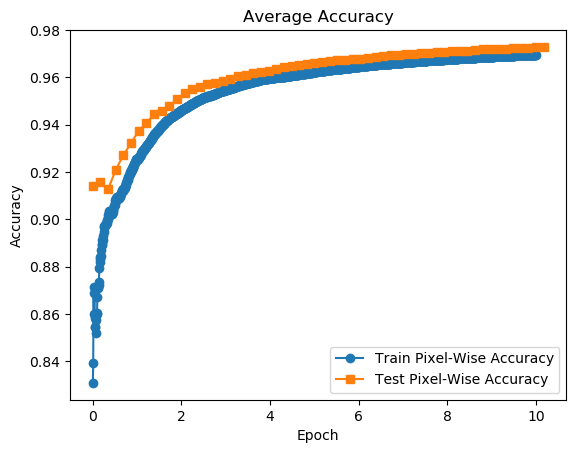

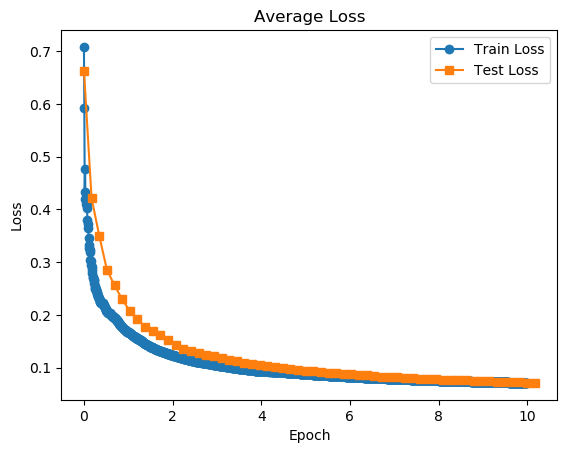

In [16]:
plt.plot(train_epoch, train_acc, label='Train Pixel-Wise Accuracy', marker='o', linestyle='-')
plt.plot(test_epoch, test_acc, label='Test Pixel-Wise Accuracy', marker='s', linestyle='-')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy')

plt.legend()
plt.show()


plt.plot(train_epoch, train_loss, label='Train Loss', marker='o', linestyle='-')
plt.plot(test_epoch, test_loss, label='Test Loss', marker='s', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss')

plt.legend()
plt.show()

Hugging Face Upload

In [24]:
model.save_pretrained("segformer-b5-finetuned-mangrove-128-128") #save weights to folder

In [18]:
# model.save_model("./my_model")

# with open('auth_token.txt', 'r') as file:
#     auth_token = file.read().strip()

# model.save_model("mpham8/segformer-b5-finetuned-mangrove-128-128", use_auth_token=auth_token)


In [23]:
for i in range(10):
    print(sum(test_acc[i*6:i*6+6])/6)

0.9204459031422934
0.9444947227140412
0.9563396810370467
0.9612286942057917
0.9649592213322068
0.9673620965981257
0.969145300021195
0.9706141218197043
0.9716115073877578
0.9725961960715069
